In [1]:
import os
os.chdir('..')
os.chdir('..')
print("Current working directory:", os.getcwd())

Current working directory: /dmj/fizmed/kchorzela/licencjat/eeg-site-effects


In [7]:
import pandas as pd
import numpy as np
import sys
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap

from src.visualization.eeg_plots import plot_eeg_feature_overview

RESULTS_PATH = 'results/tables/05_experiment_filters/patho_clf_results.csv'

PIPELINE_SAVE_DIR = 'models/05_experiment_filters/patho_clf_pipelines'
SHAP_DATA_SAVE_DIR = 'results/shap_data/05_experiment_filters/patho_clf'

METHODS = ['raw']
FEATURES = [
    'original',
    'remove_low_freq_artifacts',
    'remove_high_freq_artifacts',
    'strict_both_ends',
    'clinical_range'
]

# Analysis

In [3]:
results_df = pd.read_csv(RESULTS_PATH)

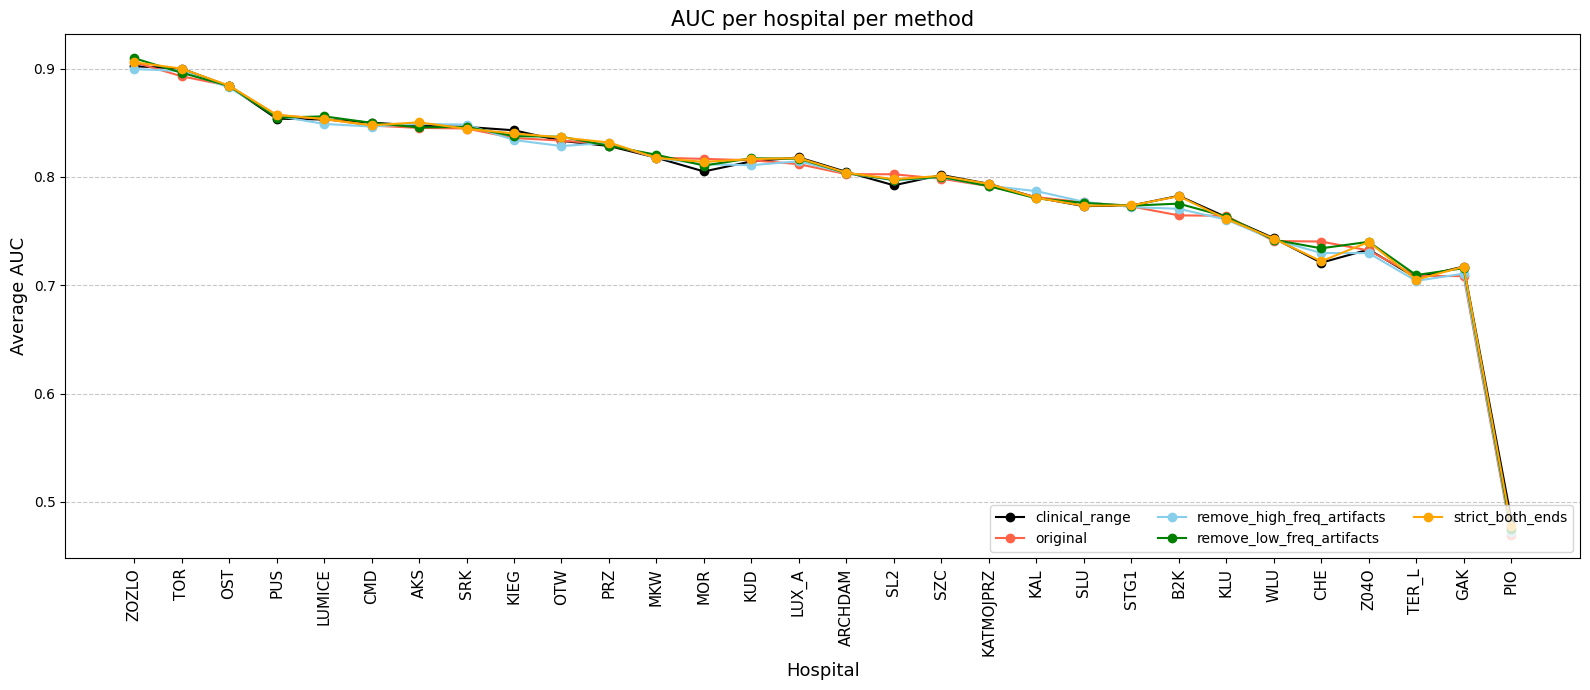

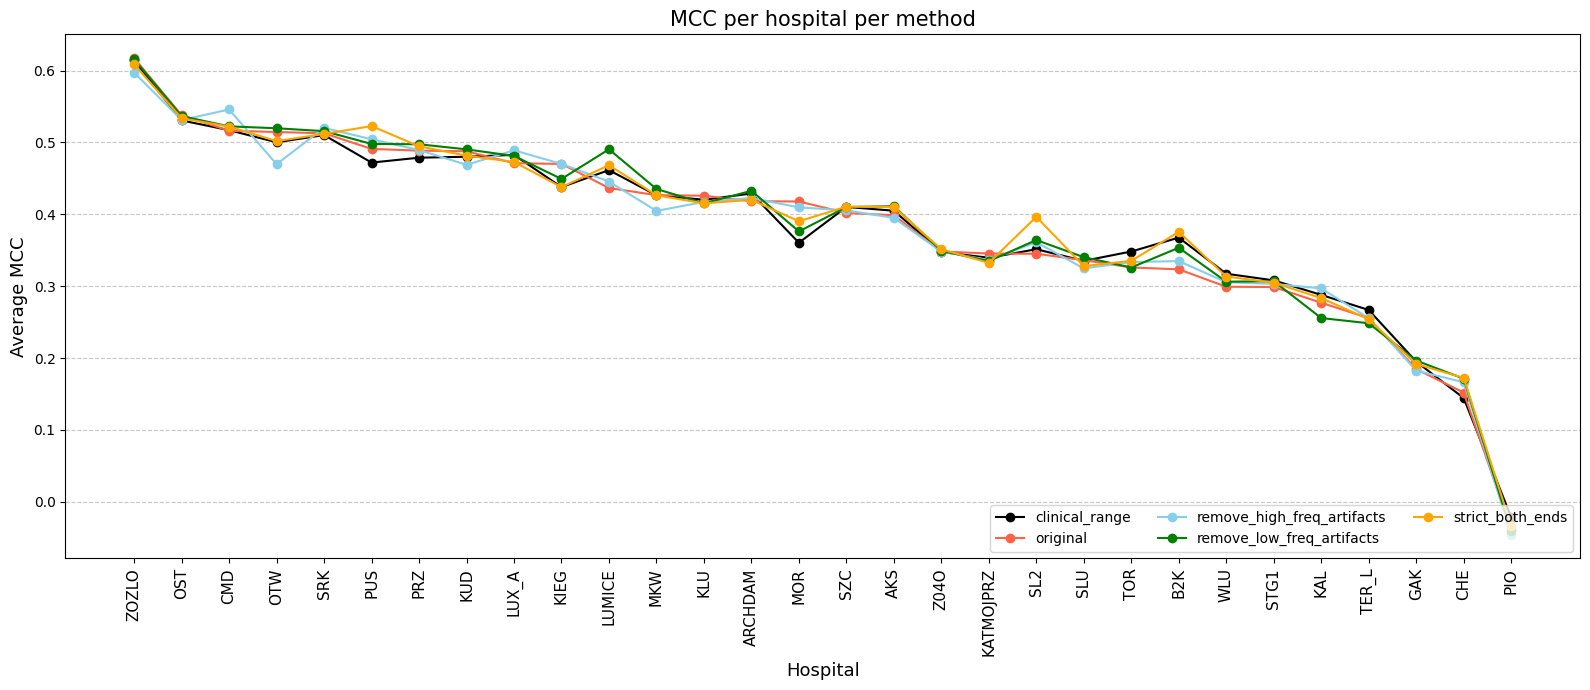

In [4]:
color_grid = [
    'tomato', 'skyblue', 'green',
    'orange', 'purple', 'brown', 'cyan',
    'magenta', 'yellow', 'pink', 'lime'
]

metrics_to_plot = ['auc', 'mcc']

for metric in metrics_to_plot:
    plt.figure(figsize=(16, 7))

    mean_results_df = results_df.pivot_table(
        index='tag',
        columns='hospital',
        values=metric,
        aggfunc='mean'
    )

    reference_series = mean_results_df.loc['original']
    sort_idx = reference_series.values.argsort()[::-1]
    hospitals_sorted = reference_series.index.values[sort_idx]

    for method_idx, method in enumerate(mean_results_df.index):
        results_series = mean_results_df.loc[method]
        values = [results_series.get(h, np.nan) for h in hospitals_sorted]

        plt.plot(
            hospitals_sorted,
            values,
            marker='o',
            linestyle='-',
            color=color_grid[method_idx % len(color_grid)],
            label=method
        )

    plt.ylabel(f"Average {metric.upper()}", fontsize=13)
    plt.xlabel("Hospital", fontsize=13)
    plt.xticks(rotation=90, fontsize=11)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    #plt.ylim(0.5, 1.1)
    plt.legend(loc='lower right', fontsize=10, ncol=3)
    plt.title(f"{metric.upper()} per hospital per method", fontsize=15)
    plt.tight_layout()
    plt.show()

### SHAP analysis

In [8]:
pipelines = {}
test_data = {}
logging.info("Loading all pipelines and test data...")
method = 'raw'
for filter in FEATURES:
    key = f"{method}_{filter}"
    pipelines[key] = {}
    test_data[key] = {}
    for hospital in hospitals_sorted:
        pipeline_path = os.path.join(PIPELINE_SAVE_DIR, f'{method}_{hospital}_{filter}_pipeline.joblib')
        pipelines[key][hospital] = joblib.load(pipeline_path)

        data_path = os.path.join(SHAP_DATA_SAVE_DIR, f'{method}_{hospital}_{filter}_test_data.parquet')
        test_data[key][hospital] = pd.read_parquet(data_path)

In [9]:
transformed_X = {}
feature_names = {}
method = 'raw'
for filter in FEATURES:
    key = f"{method}_{filter}"
    transformed_X[key] = {}
    feature_names[key] = {}
    for hospital in hospitals_sorted:
        pipeline = pipelines[key][hospital]
        data_df = test_data[key][hospital]

        y_test = data_df['y_true']
        X_test = data_df.drop(columns=['y_true'])

        model = pipeline.named_steps['clf']
        feature_names[key][hospital] = model.feature_names_

        if method == 'raw':
            X_transformed = X_test
        else:
            X_transformed = pipeline.named_steps['harmonize'].transform(X_test)

        transformed_X[key][hospital] = pd.DataFrame(X_transformed, columns=feature_names[key][hospital])

In [10]:
shap_values = {}
explainers = {}
method = 'raw'
for filter in FEATURES:
    key = f"{method}_{filter}"
    shap_values[key] = {}
    explainers[key] = {}
    for hospital in hospitals_sorted:
        model = pipelines[key][hospital].named_steps['clf']
        X = transformed_X[key][hospital]

        explainers[key][hospital] = None
        shap_values[key][hospital] = model.compute_shap_values(X)

In [11]:
method = 'raw'
for filter in FEATURES:
    key = f"{method}_{filter}"
    mean_abs_shap = np.mean(
        [np.abs(shap_values[key][h].values).mean(axis=0) for h in shap_values[key].keys()],
        axis=0
    )
    shap_series = pd.Series(mean_abs_shap, index=transformed_X[key]['AKS'].columns) # Any hospital...
    print(key)
    fig, axs = plot_eeg_feature_overview(
        features_series=shap_series,
        figure_title=f"Method: {method}, Filter: {filter}"
    )
    save_path = f"results/figures/05_experiment_filters/pathology_clf/{key}_shap_overview.png"
    fig.savefig(save_path, dpi=150, bbox_inches='tight')
    logging.info(f"Saved plot to {save_path}")

    plt.close(fig)

raw_original
raw_remove_low_freq_artifacts
raw_remove_high_freq_artifacts
raw_strict_both_ends
raw_clinical_range


In [12]:
method = 'raw'
for filter in FEATURES:
    key = f"{method}_{filter}"
    for hospital_id, shap_array in shap_values[key].items():
        mean_abs_shap = np.abs(shap_array.values).mean(axis=0)
        shap_series = pd.Series(mean_abs_shap, index=transformed_X[key][hospital_id].columns)
        print(key)
        fig, axs = plot_eeg_feature_overview(
            features_series=shap_series,
            figure_title=f"Method: {method}, Filter: {filter}, Hospital ID: {hospital_id}"
        )

        save_path_dir = f"results/figures/05_experiment_filters/pathology_clf/{key}"
        os.makedirs(save_path_dir, exist_ok=True)
        save_path = save_path_dir + f"/{key}_{hospital_id}_shap_overview.png"
        fig.savefig(save_path, dpi=150, bbox_inches='tight')
        logging.info(f"Saved plot to {save_path}")

        plt.close(fig)

raw_original
raw_original
raw_original
raw_original
raw_original
raw_original
raw_original
raw_original
raw_original
raw_original
raw_original
raw_original
raw_original
raw_original
raw_original
raw_original
raw_original
raw_original
raw_original
raw_original
raw_original
raw_original
raw_original
raw_original
raw_original
raw_original
raw_original
raw_original
raw_original
raw_original
raw_remove_low_freq_artifacts
raw_remove_low_freq_artifacts
raw_remove_low_freq_artifacts
raw_remove_low_freq_artifacts
raw_remove_low_freq_artifacts
raw_remove_low_freq_artifacts
raw_remove_low_freq_artifacts
raw_remove_low_freq_artifacts
raw_remove_low_freq_artifacts
raw_remove_low_freq_artifacts
raw_remove_low_freq_artifacts
raw_remove_low_freq_artifacts
raw_remove_low_freq_artifacts
raw_remove_low_freq_artifacts
raw_remove_low_freq_artifacts
raw_remove_low_freq_artifacts
raw_remove_low_freq_artifacts
raw_remove_low_freq_artifacts
raw_remove_low_freq_artifacts
raw_remove_low_freq_artifacts
raw_remove